In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib

import warnings
warnings.filterwarnings("ignore")

In [2]:
def dataset_analysis(path):
    subfolders = os.listdir(path)

    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  # Mode (e.g., RGB, L)
                        
                        
                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"
                        
                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")
                    
            print('--------'*10)
            print(f"Subfolder '{subfolder}' contains ({len(files)} files):")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"- {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"  - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")
                        


path = r'C:/Users/rajiv/OneDrive/Desktop/archive/dataset'
dataset_path = path
dataset_analysis(dataset_path)

--------------------------------------------------------------------------------
Subfolder 'cataract' contains (1038 files):
- 938 images of format JPEG:
  - 298 images with dimensions (512, 512), bit depth 24, mode RGB
  - 640 images with dimensions (256, 256), bit depth 24, mode RGB
- 100 images of format PNG:
  - 76 images with dimensions (2592, 1728), bit depth 24, mode RGB
  - 5 images with dimensions (1848, 1224), bit depth 24, mode RGB
  - 19 images with dimensions (2464, 1632), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'diabetic_retinopathy' contains (1098 files):
- 1098 images of format JPEG:
  - 1098 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'glaucoma' contains (1007 files):
- 906 images of format JPEG:
  - 306 images with dimensions (512, 512), bit depth 24, mode RGB
  - 600 images with dimensions (

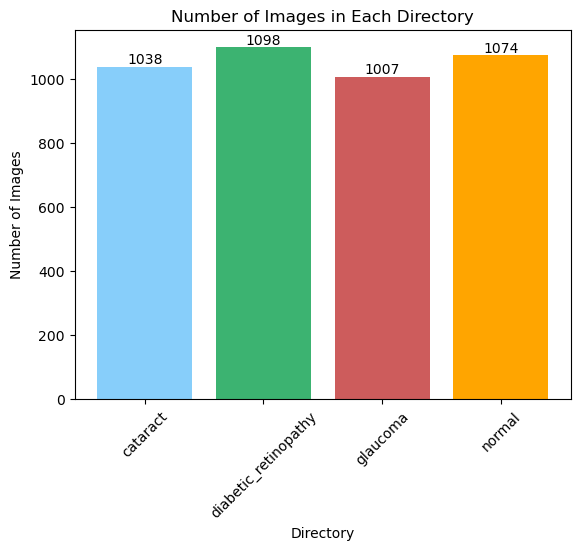

In [3]:
subfolders = os.listdir(path)

image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)
        
#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i], str(image_counts[i]), ha='center', va='bottom')
    
#Set some colors
colors = ['lightskyblue', 'mediumseagreen', 'indianred', 'orange']

# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Directory')
plt.xticks(rotation = 45)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.show()

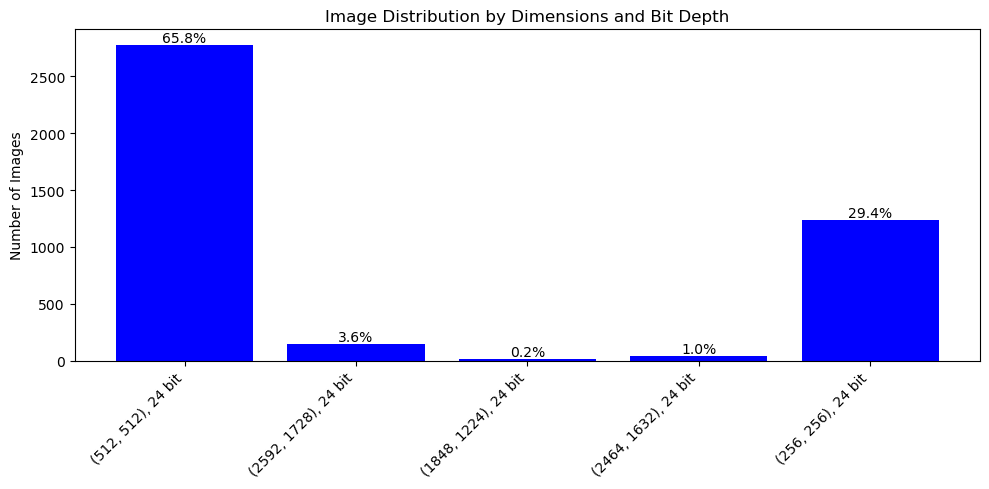

In [4]:
def dataset_size_analysis(path):
    format_dimensions_counts = defaultdict(int)

    subfolders = os.listdir(path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_dimensions = img.size
                        image_mode = img.mode

                        # Calculate bit depth
                        bit_depth = {
                            "1": 1,
                            "L": 8,
                            "P": 8,
                            "RGB": 24,
                            "RGBA": 32,
                            "CMYK": 32
                        }.get(image_mode, "Unknown")

                        # Update counts
                        format_dimensions_counts[(image_dimensions, bit_depth)] += 1

                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Plotting dimensions and bit depths
    plt.figure(figsize=(10, 5))
    labels = [f"{dims}, {depth} bit" for (dims, depth) in format_dimensions_counts]
    sizes = list(format_dimensions_counts.values())
    total = sum(sizes)
    bars = plt.bar(labels, sizes, color='blue')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval/total:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)

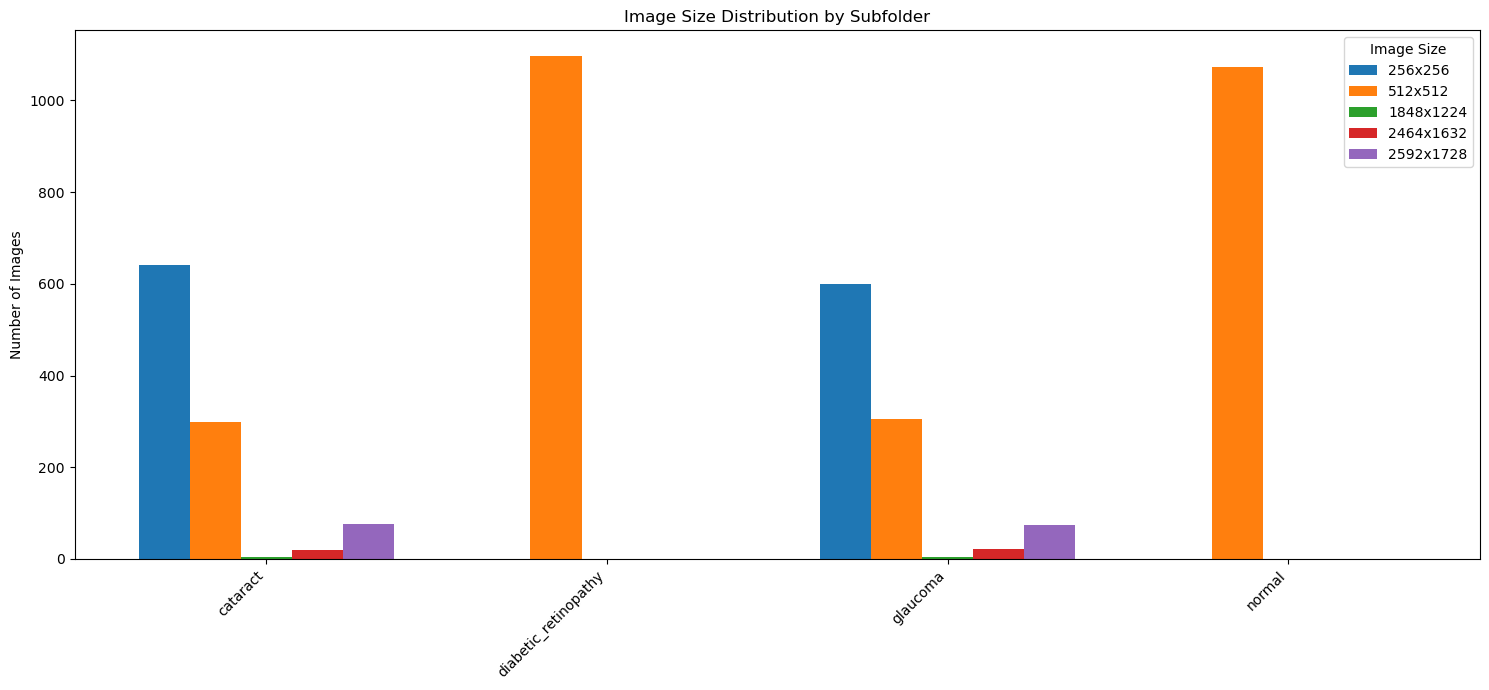

In [5]:
def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))
    
    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Size Distribution by Subfolder')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)

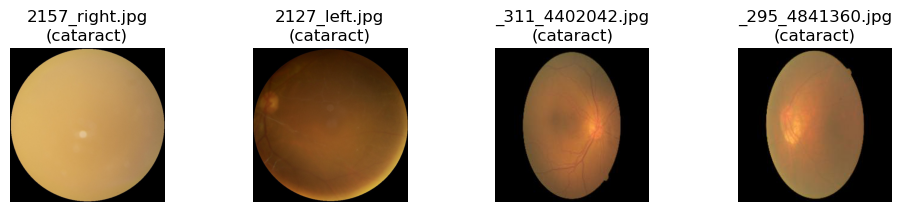

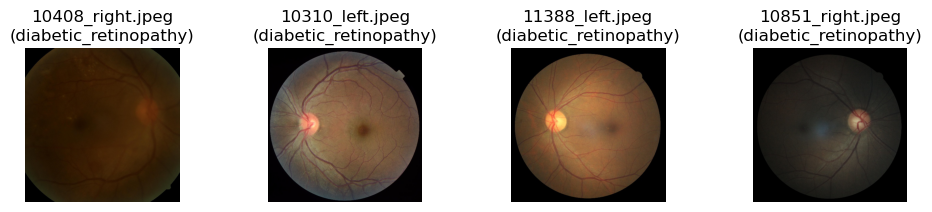

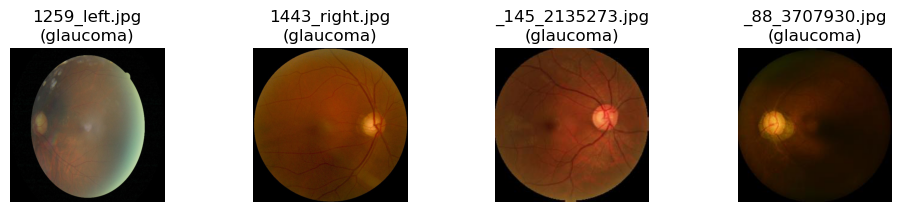

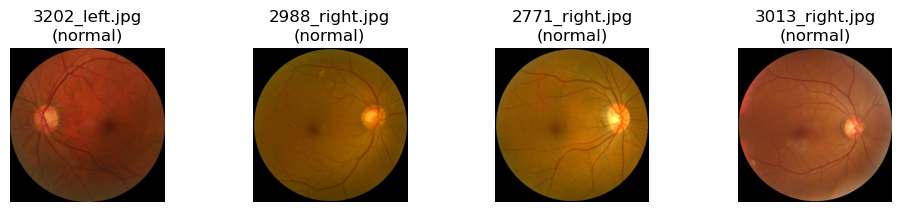

In [6]:
def random_photos_from_folders(base_folder):
    # Walk through all directories and files in the base_folder
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images
            
            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))  # Create a 1x4 grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes
                
                # Extract sub-folder name from the root path
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")
                
            plt.show()

# Path to the folder containing sub-folders with images

random_photos_from_folders(path)

In [7]:
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# create data path and their labeles
data = []
labels = []
extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

for i in class_dirs:
    class_label = i
    image_files = []
    for ext in extensions:
        # Search for files with each extension and extend the image_files list
        image_files.extend(glob.glob(os.path.join(path, i, f"*.{ext}")))
    data.extend(image_files)
    labels.extend([class_label] * len(image_files))

# Check if lists are still empty
if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print("Files found and listed.")


# Create a DataFrame with the image paths and labels
df = pd.DataFrame({
'filename': data,
'class': labels
})


# Shuffle the dataset by rows
df = df.sample(frac=1)

Files found and listed.


In [8]:
display(df)

,filename,class
380,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,cataract
407,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,cataract
1644,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,cataract
7896,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,normal
4912,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,glaucoma
...,...,...
1749,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,cataract
2885,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,diabetic_retinopathy
7652,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,normal
4535,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,glaucoma


In [9]:
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


In [10]:
display(df)

,filename,class
380,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,0
407,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,0
1644,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,0
7896,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,3
4912,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,2
...,...,...
1749,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,0
2885,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,1
7652,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,3
4535,C:/Users/rajiv/OneDrive/Desktop/archive/datase...,2


In [11]:
print(df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Now you have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))

1    0.260375
3    0.254683
0    0.246147
2    0.238795
Name: class, dtype: float64
------------------------------------------------------------
Training set:
1    0.260474
3    0.254545
0    0.246245
2    0.238735
Name: class, dtype: float64
------------------------------------------------------------
Validation set:
1    0.260225
3    0.254890
0    0.245999
2    0.238886
Name: class, dtype: float64
------------------------------------------------------------
Test set:
1    0.260225
3    0.254890
0    0.245999
2    0.238886
Name: class, dtype: float64


In [12]:
train_links, train_labels = train['filename'].values , train['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values

In [13]:
def load_and_preprocess_image(path, label, data_augmentation=True):
    # Read the image file
    image = tf.io.read_file(path)
    
    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]
    
    # Decode based on file extension using tf.cond
    def decode_jpeg():
        return tf.image.decode_jpeg(image, channels=3)
    
    def decode_png():
        return tf.image.decode_png(image, channels=3)
    
    def decode_bmp():
        return tf.image.decode_bmp(image, channels=3)
    
    def decode_gif():
        # Decode GIF and take the first frame
        return tf.squeeze(tf.image.decode_gif(image), axis=0)
    
    # Handle each format
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
            lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
            lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
            decode_jpeg)))))
    
    # Resize and normalize
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range

    # Apply data augmentation if in training mode
    if data_augmentation == True:
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)
        
        # Randomly flip the image vertically
        image = tf.image.random_flip_up_down(image)
        
        # Randomly rotate the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        
        # Randomly adjust brightness
        image = tf.image.random_brightness(image, max_delta=0.1)
        
        # Randomly zoom in
        image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
        image = tf.image.random_crop(image, size=[256, 256, 3])
        
        # Randomly adjust contrast
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        
    return image, label

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_links , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices( (val_links , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_links , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy()}, Label: {label_element.numpy()}")

Data: [[[0.02291831 0.01763397 0.00887719]
  [0.05219147 0.03942439 0.04189172]
  [0.05219147 0.03942439 0.04189172]
  ...
  [0.05219147 0.04316577 0.03066759]
  [0.05219147 0.04316577 0.03066759]
  [0.05219147 0.03942439 0.03440897]]

 [[0.02291831 0.01763397 0.00887719]
  [0.05219147 0.03942439 0.04189172]
  [0.05219147 0.03942439 0.04189172]
  ...
  [0.05219147 0.04316577 0.03066759]
  [0.05219147 0.04316577 0.03066759]
  [0.05219147 0.03942439 0.03440897]]

 [[0.02291831 0.01763397 0.00887719]
  [0.05219147 0.03942439 0.03440897]
  [0.05219147 0.03942439 0.03440897]
  ...
  [0.05219147 0.03942439 0.03440897]
  [0.05219147 0.03942439 0.03440897]
  [0.05219147 0.03942439 0.03440897]]

 ...

 [[0.02291831 0.01763397 0.00887719]
  [0.05219147 0.03942439 0.03440897]
  [0.05219147 0.03942439 0.03440897]
  ...
  [0.05219147 0.03942439 0.03440897]
  [0.05219147 0.03942439 0.03440897]
  [0.05219147 0.03942439 0.03440897]]

 [[0.02291831 0.01763397 0.00887719]
  [0.05219147 0.03942439 0.0344

In [16]:
for data_element, label_element in train_dataset.take(1):  # Adjust the number to print more/less
    print(f"Data: {data_element.numpy().shape}, Label: {label_element.numpy()}")

Data: (256, 256, 3), Label: 1


In [17]:
batch_size = 16

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
model = models.Sequential([
    # First Block
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),



    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 256)     295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 256)     5

In [19]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=12,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=r'best_model.h5',  # Path to save the model file
    monitor='val_loss',  # Change to val_loss to monitor the validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the monitored metric has minimized
    ''
)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
    


# Fit the model
history = model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 50,
    callbacks=[early_stopping , model_checkpoint]  # Add the EarlyStopping callback
)

Epoch 1/50
317/317 [==============================] - ETA: 0s - loss: 1.3611 - accuracy: 0.3791 
Epoch 1: val_loss improved from inf to 1.35895, saving model to best_model.h5
317/317 [==============================] - 3519s 11s/step - loss: 1.3611 - accuracy: 0.3791 - val_loss: 1.3589 - val_accuracy: 0.4659
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 1.1768 - accuracy: 0.4735 
Epoch 2: val_loss did not improve from 1.35895
317/317 [==============================] - 3513s 11s/step - loss: 1.1768 - accuracy: 0.4735 - val_loss: 1.5552 - val_accuracy: 0.3533
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 1.1169 - accuracy: 0.5008 
Epoch 3: val_loss improved from 1.35895 to 1.14592, saving model to best_model.h5
317/317 [==============================] - 3505s 11s/step - loss: 1.1169 - accuracy: 0.5008 - val_loss: 1.1459 - val_accuracy: 0.4855
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.5263 
Epo

Epoch 29/50
317/317 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8929 
Epoch 29: val_loss did not improve from 0.26989
317/317 [==============================] - 3570s 11s/step - loss: 0.2828 - accuracy: 0.8929 - val_loss: 0.3200 - val_accuracy: 0.8720
Epoch 30/50
317/317 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.8917 
Epoch 30: val_loss did not improve from 0.26989
317/317 [==============================] - 3526s 11s/step - loss: 0.2836 - accuracy: 0.8917 - val_loss: 0.2847 - val_accuracy: 0.8838
Epoch 31/50
317/317 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8980 
Epoch 31: val_loss improved from 0.26989 to 0.25521, saving model to best_model.h5
317/317 [==============================] - 3662s 12s/step - loss: 0.2759 - accuracy: 0.8980 - val_loss: 0.2552 - val_accuracy: 0.9004
Epoch 32/50
317/317 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8947 
Epoch 32: val_loss did not 

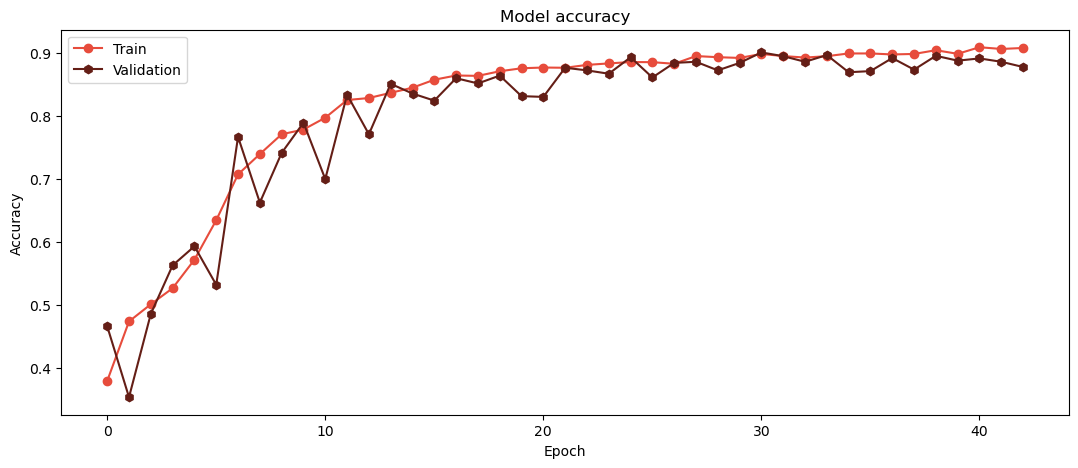

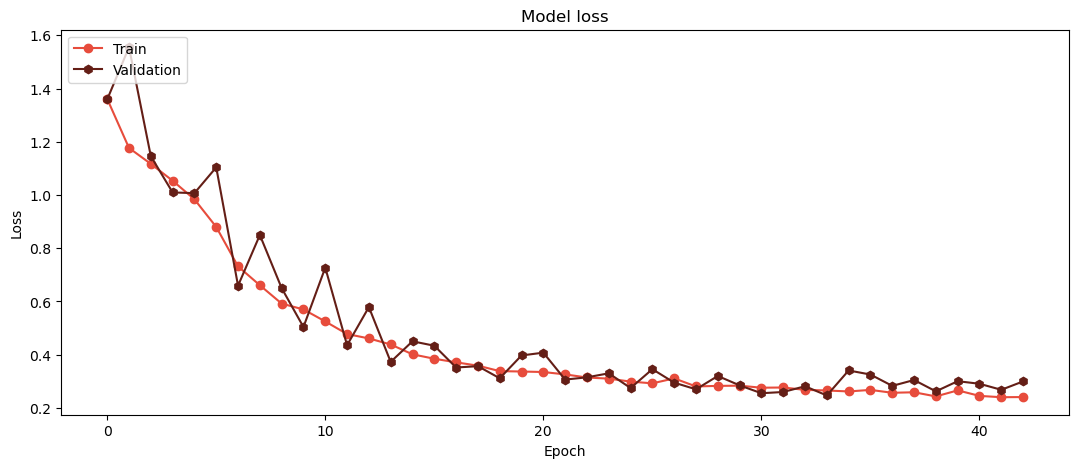

In [20]:
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
best_model = load_model(r'best_model_custom.h5')



# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

106/106 [==============================] - 268s 3s/step - loss: 0.3143 - accuracy: 0.8678
train loss: 0.3467877507209778
train accuracy: 0.8677865862846375
------------------------
val loss: 0.30899664759635925
val accuracy: 0.8749259114265442
------------------------
Test loss: 0.3143042027950287
Test accuracy: 0.8678126931190491


In [22]:
y_pred = np.argmax( best_model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

Confusion Matrix:
[[367   2  24  22]
 [  0 434   1   4]
 [ 37   7 263  96]
 [  7   4  19 400]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.89      0.88      0.89       415
diabetic_retinopathy       0.97      0.99      0.98       439
            glaucoma       0.86      0.65      0.74       403
              normal       0.77      0.93      0.84       430

            accuracy                           0.87      1687
           macro avg       0.87      0.86      0.86      1687
        weighted avg       0.87      0.87      0.86      1687



Total Number Of Test data:  1687


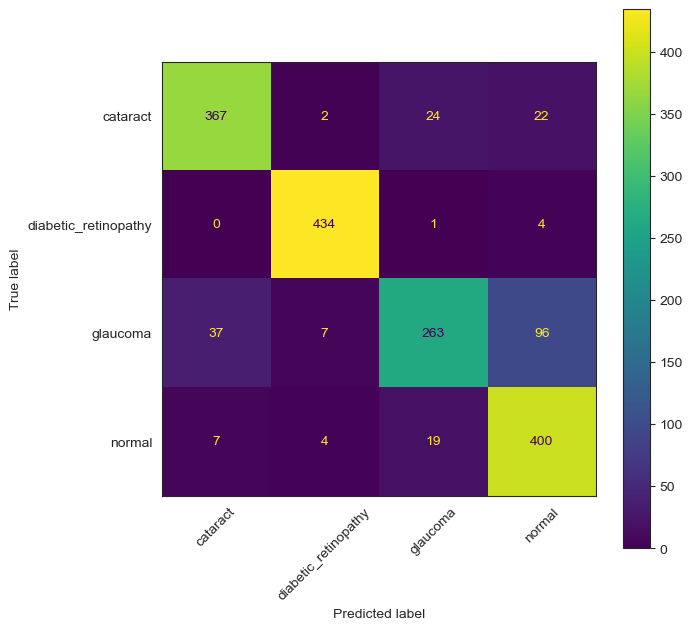

In [23]:
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches 
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

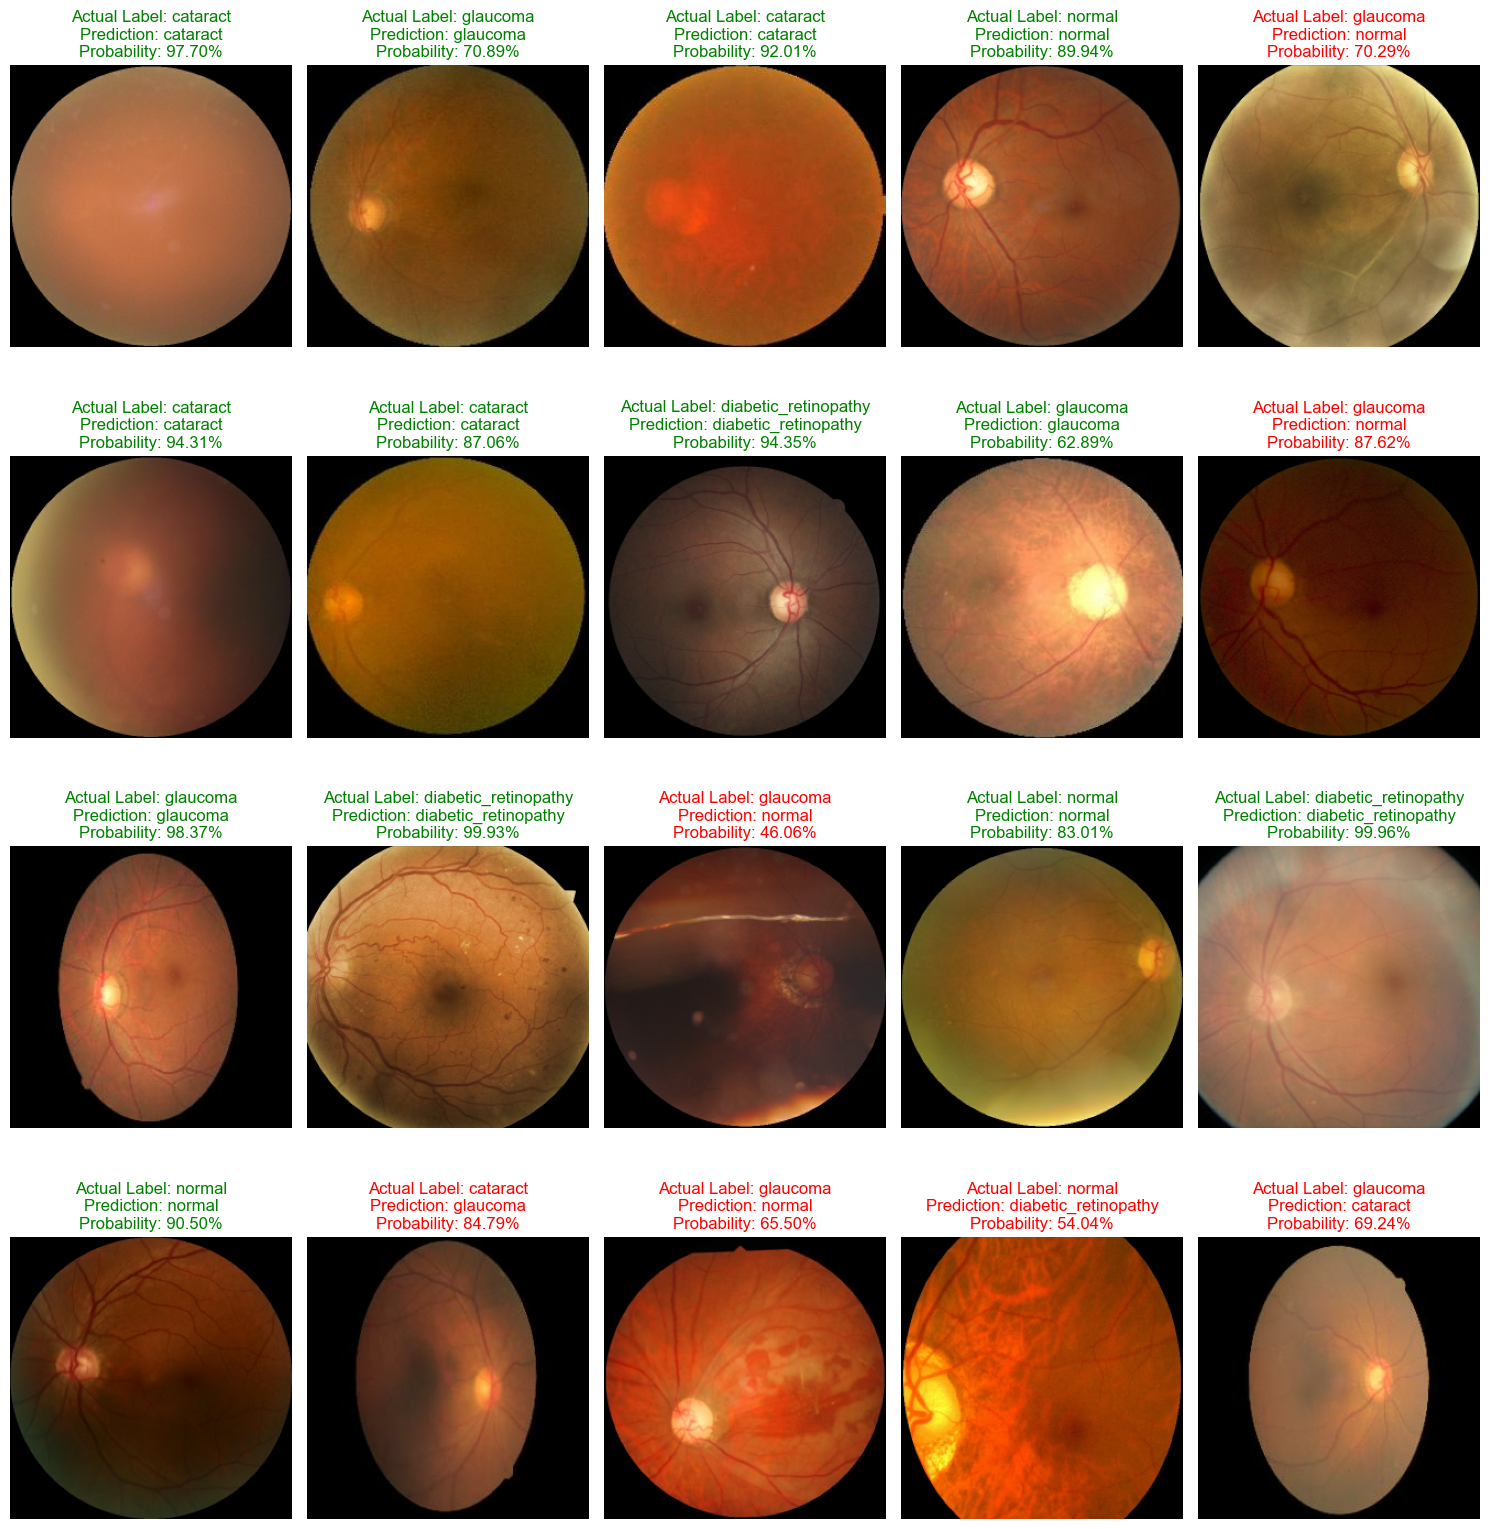

In [24]:
def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(best_model, test_dataset, class_labels=class_names, num_images=20)